# Computing the S isotope fractionation factors for the oxidation of S0 to sulfate by Desulfurivibrio alkaliphilus from experimental data

In [400]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [401]:
# Import table with data
df_data =  pd.read_csv ('/Users/daniosro/git/MSO/d_alk/data/raw/EA/202202_EA.csv')

#Remove NaN cells
df_data = df_data.dropna(subset=['Identifier'])

# Keep only rows with Peak Nr=3, since Peak Nr=1,2,4 and 5 
# correspond to the reference gas
#Select rows to drop
df_data = df_data[df_data.Peak_Nr == 3]

df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,sample,sulfide,20220212
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,sample,sulfide,20220212
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,sample,sulfide,20220212


Then, let's load the data for the blanks:

In [402]:
# Import table with the raw data for blanks
df_blanks = pd.read_csv('/Users/daniosro/git/MSO/d_alk/data/raw/EA/202202_blanks.csv')

# Remove rows with missing data
df_blanks.dropna(how='any', inplace=True)

# Keep only rows with Peak Nr=3
df_blanks = df_blanks[df_blanks.Peak_Nr == 3]
df_blanks.head()

,Identifier,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Date
2,Blank-1,3,0.448,17,0.428,0.021,80,0.029,20220212
7,Blank-2,3,0.518,18,0.494,0.024,86,1.703,20220212
12,Blank,3,0.601,21,0.573,0.028,98,0.328,20220212
17,Blank,3,4.985,165,4.757,0.229,792,1.619,20220212
22,Blank-2,3,1.518,56,1.449,0.069,265,-0.458,20220215


Finally, let's load the data for the linearity test at the beginning of the run:

In [403]:
# Import file
df_lin =  pd.read_csv('/Users/daniosro/git/MSO/d_alk/data/raw/EA/202202_linearity.csv')
df_lin.head()

,Identifier,Peak_Nr,Ampl_64,Ampl_66,d34S,Date
0,linearity,1,510,2446,-0.153,20220212
1,linearity,2,1729,8294,0.000,20220212
2,linearity,3,2614,12544,0.044,20220212
3,linearity,4,3165,15187,0.068,20220212
4,linearity,5,4317,20718,0.143,20220212


Now, let's implement the corrections.

## Blank correction

In [404]:
# Get the average area all for the blanks
blank_area_all_average = df_blanks["Area_All"].mean()

# Get the average d34S for the blanks
blank_d34s_average = df_blanks["d34S"].mean()

# Append a column to the data dataframe with the 
# correction of area by blank: substraction of the
# area of the measurement by the area of the blank

df_data['Correction_of_area_blank'] = \
    np.subtract(df_data['Area_All'], blank_area_all_average)

# Correction of d34S by blank: 
    
# Get the product of the d34S by the area of each measurement
num1 = np.multiply (df_data['d34S'], df_data['Area_All'])
# Get the product of the d34S by the area of the average of the blanks
num2 = blank_d34s_average * blank_area_all_average  
#Subtract the product of d34S by the product of the blanks
num = np.subtract (num1, num2)
#Divide by the area corrected by blank and
#append column to the data dataframe
df_data['Correction_of_d34S_blank'] = \
    np.divide (num, df_data['Correction_of_area_blank'])

df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,sample,sulfide,20220212,4.9756,-5.413624
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,sample,sulfide,20220212,8.5476,-5.228882
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,sample,sulfide,20220212,8.3536,-5.692407


## Linearity correction

In [405]:
# Create variables for linear regression
# x will be the amplitude of the peak of mass 64 = ^32S + ^16O + ^16O
# We divided by 1000 to convert volts ot milivolts
x = (df_lin['Ampl_64'].values/1000).reshape((-1,1))
# y will be the values of d34S
y = (df_lin['d34S'])

# Create model of linear regression
model = LinearRegression().fit(x,y)

#Determine R square, intercept and slope
r_sq = model.score(x,y)
intercept = model.intercept_
s = model.coef_
slope=s[0]

# Calculate an amplitude difference by centering around an arbitrary 
# value in the Ampl_64 column of the data dataframe  
num= np.subtract(df_data['Ampl_64'], 1500)
ampl_difference = np.divide (num, 1000)

# Calculate the amplitude correction factor
ampl_correction_factor = (slope * ampl_difference)+intercept

# Correct the d34S corrected by amplitude by
# subtracting the blank corrected data by the amplitude correction
# factor and append the column to the data dataframe
df_data['Correction_of_d34S_by_amplitude'] = \
    np.subtract(df_data['Correction_of_d34S_blank'], ampl_correction_factor)

df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537,-11.351091
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.765174
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,sample,sulfide,20220212,4.9756,-5.413624,-4.764831
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,sample,sulfide,20220212,8.5476,-5.228882,-4.606763
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,sample,sulfide,20220212,8.3536,-5.692407,-5.069153


## Standard correction 

First, let's create a category column in the dataframe according to the size of the area of the peak of each sample and standard.

In [406]:
# Correct each sample by standards with similar areas

#Create standard correction group empty list
Std_group = []
# Classify the area of the samples by category 
# Loop through dataframe rows
for row in df_data['Area_All']:
    if row <= 30:
        Std_group.append ('low')
    else:
        Std_group.append ('high')
# Append to data dataframe 
df_data['Std_group'] = Std_group
df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537,-11.351091,low
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.765174,low
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,sample,sulfide,20220212,4.9756,-5.413624,-4.764831,low
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,sample,sulfide,20220212,8.5476,-5.228882,-4.606763,low
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,sample,sulfide,20220212,8.3536,-5.692407,-5.069153,low


In [407]:
# Create df with only standard data
df_standards = df_data[(df_data.Type == 'standard')] 
#Sort values by ID and area
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])

df_standards.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.765174,low
227,AGS_2,NaN,NaN,3,16.525,620,15.769,0.756,2972,0.901,standard,NaN,20220215,13.6396,1.103971,1.687310,low
507,AGS_2,NaN,NaN,3,20.478,764,19.541,0.938,3663,0.793,standard,NaN,20220217,17.5926,0.932651,1.488749,low
782,AGS_2,NaN,NaN,3,23.782,890,22.693,1.089,4266,0.587,standard,NaN,20220218,20.8966,0.676126,1.208388,low
147,AGS_2,NaN,NaN,3,24.094,894,22.992,1.102,4283,0.758,standard,NaN,20220215,21.2086,0.869079,1.400585,low


In [408]:
# Calculate the slope and intercept for calculated vs. true value of the stds

# Append true value column to the standard table
# For AGS_2
df_standards.loc[df_standards['Identifier'] \
                  == 'AGS_2', 'True_d34S'] = 1.89
# For SW
df_standards.loc[df_standards['Identifier'] \
                  == 'SW', 'True_d34S'] = 21

# For SID9
df_standards.loc[df_standards['Identifier'] \
                  == 'SID9', 'True_d34S'] = -9.55
                       
# Group by Std_group
df_stdgroup = df_standards.groupby (['Std_group'])

df_standards.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,True_d34S
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.765174,low,1.89
227,AGS_2,NaN,NaN,3,16.525,620,15.769,0.756,2972,0.901,standard,NaN,20220215,13.6396,1.103971,1.687310,low,1.89
507,AGS_2,NaN,NaN,3,20.478,764,19.541,0.938,3663,0.793,standard,NaN,20220217,17.5926,0.932651,1.488749,low,1.89
782,AGS_2,NaN,NaN,3,23.782,890,22.693,1.089,4266,0.587,standard,NaN,20220218,20.8966,0.676126,1.208388,low,1.89
147,AGS_2,NaN,NaN,3,24.094,894,22.992,1.102,4283,0.758,standard,NaN,20220215,21.2086,0.869079,1.400585,low,1.89


Below, we make a linear regression for the standards of each area group.

In [409]:
# Get the slope and intercept for the standards of each group
# Define column names
names = ['Std_group', 'R squared', 'Intercept', 'Slope']

# Initialize empty dataframe to save fit results
df_linreg_stds = pd.DataFrame(columns=names)
                 
# Create variables for linear regression
#Loop through standard groups                       
for group, data in enumerate (df_stdgroup):
    #x will be the values of d34S of the stds corrected by blanks and linearity
    x_std = data[1].Correction_of_d34S_by_amplitude.values.reshape((-1,1))
    #y will be the true values of d34S of each standard
    y_std = data[1].True_d34S
    # Create model
    model = LinearRegression().fit(x_std,y_std)
    #Determine R square, intercept and slope
    r_sq_stds = model.score(x_std,y_std)
    intercept_stds = model.intercept_
    s1 = model.coef_
    slope_stds = s1[0]
    # Store parameters and group as list
    params = (data[1].Std_group.unique(), r_sq_stds, intercept_stds, slope_stds)
 
    # Convert list to pandas Series
    series = pd.Series(params, index=names)   
    # Append parameters to dataframe
    df_linreg_stds = df_linreg_stds.append(series, ignore_index=True)
#Round the values of the dataframe to two decimal places
df_linreg_stds = df_linreg_stds.round(2)     
df_linreg_stds 

,Std_group,R squared,Intercept,Slope
0,[high],1.0,0.69,1.04
1,[low],1.0,0.58,0.98


Finally, let's apply the standard correction to the samples based on their area:

In [410]:
#Apply corrections by true value and area

# Initialize lists to save values
slopes = []
intercepts = []
Correction_of_d34S_by_true_value = []

#loop through rows in dataframe
for index, row in df_data.iterrows():
    # Extract standard group
    Std_group = row.Std_group
    # Extract slope and intercept
    slope = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Slope.iloc[0]
    intercept = df_linreg_stds[df_linreg_stds.Std_group == Std_group].Intercept.iloc[0]
    slopes.append(slope)
    intercepts.append(intercept)
    # Compute corrected concentration
    Correction_of_d34S_by_true_value.append(intercept + slope * row.Correction_of_d34S_by_amplitude)
    
# Append values to dataframe
df_data['Correction_of_d34S_by_true_value'] = Correction_of_d34S_by_true_value

df_data.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
2,SID9,NaN,NaN,3,16.605,593,15.851,0.753,2813,-9.875,standard,NaN,20220212,13.7196,-11.939537,-11.351091,low,-10.544069
7,AGS_2,NaN,NaN,3,13.093,481,12.494,0.599,2306,0.888,standard,NaN,20220212,10.2076,1.155539,1.765174,low,2.309870
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,sample,sulfide,20220212,4.9756,-5.413624,-4.764831,low,-4.089535
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,sample,sulfide,20220212,8.5476,-5.228882,-4.606763,low,-3.934627
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,sample,sulfide,20220212,8.3536,-5.692407,-5.069153,low,-4.387770


Since all the corrections have been done, we will now export the corrected data, which must be combined with the quantification data to get the plots of sulfide degradation and change in the $\delta^{34}S$ of the remaining sulfide as a function of time or -ln of sulfide remaining.

In [411]:
# Create dataframe that includes only data from the samples
df_samples = df_data[(df_data.Type == 'sample')]

# Export data table
df_samples.to_csv('/Users/daniosro/git/MSO/d_alk/data/processed/EA/202202_EA.csv')
df_samples.head()

,Identifier,Time_h,Replicate,Peak_Nr,Area_All,Ampl_64,Area_64,Area_66,Ampl_66,d34S,Type,Measurement,Date,Correction_of_area_blank,Correction_of_d34S_blank,Correction_of_d34S_by_amplitude,Std_group,Correction_of_d34S_by_true_value
12,Control,0.0,1.0,3,7.861,274,7.502,0.358,1309,-3.448,sample,sulfide,20220212,4.9756,-5.413624,-4.764831,low,-4.089535
17,Control,33.5,1.0,3,11.433,415,10.911,0.521,1982,-3.924,sample,sulfide,20220212,8.5476,-5.228882,-4.606763,low,-3.934627
22,Control,54.5,1.0,3,11.239,409,10.727,0.512,1949,-4.246,sample,sulfide,20220212,8.3536,-5.692407,-5.069153,low,-4.387770
27,Control,71.0,1.0,3,8.938,311,8.530,0.408,1484,-3.893,sample,sulfide,20220212,6.0526,-5.721002,-5.079208,low,-4.397624
32,Control,83.0,1.0,3,10.134,355,9.672,0.462,1694,-3.698,sample,sulfide,20220212,7.2486,-5.146764,-4.513294,low,-3.843028


### Analytical repeatability of measurements

Let's calculate the analytical repeatability of the EA-IRMS measurements. 

In [412]:
# Update standard df
# Create a dataframe for only standards from the updated data dataframe
df_standards = df_data[(df_data.Type == 'standard')]

#Sort values
df_standards = df_standards.sort_values(['Identifier', 'Area_All'])

#Group standards by identifier and area
grouped_standards = df_standards.groupby(['Identifier', 'Std_group'])

# Determine the mean of each standard  and rename the series
mean_stds = grouped_standards['Correction_of_d34S_by_true_value'].mean()
mean_stds = mean_stds.rename("d34S_mean")

# Determine the standard deviation of each standard  and rename the series
std_dev_stds = grouped_standards['Correction_of_d34S_by_true_value'].std()
std_dev_stds = std_dev_stds.rename("d34S_stdev")

#Pass series to individual dataframes
df_mean_stds=mean_stds.to_frame()
df_std_dev_stds=std_dev_stds.to_frame()

In [413]:
#Merge the mean and standard deviation dataframes
df_anrep = pd.merge(df_mean_stds, df_std_dev_stds,  how='outer', on=['Identifier', 'Std_group'])

#Reset index of the dataframe
df_anrep = df_anrep.reset_index()

#Add column of true value of the standards
df_anrep.loc[df_anrep['Identifier'] \
                  == 'AGS_2', 'True_d34S'] = 1.89
df_anrep.loc[df_anrep['Identifier'] \
                  == 'SW', 'True_d34S'] = 21
df_anrep.loc[df_anrep['Identifier'] \
                  == 'SID9', 'True_d34S'] = -9.55

#Determine the accuracy by subtracting the true value from the average value of each standard
df_anrep ['Accuracy'] = abs(df_anrep ['True_d34S'] - df_anrep ['d34S_mean'])
df_anrep

,Identifier,Std_group,d34S_mean,d34S_stdev,True_d34S,Accuracy
0,AGS_2,high,2.312135,0.124458,1.89,0.422135
1,AGS_2,low,2.047861,0.183298,1.89,0.157861
2,SID9,high,-9.707573,0.547362,-9.55,0.157573
3,SID9,low,-9.713270,0.981630,-9.55,0.163270
4,SW,high,20.847383,1.075341,21.00,0.152617
5,SW,low,20.707950,1.303076,21.00,0.292050


## Import the quantification data and calculate the fraction of sulfate produced

Let's begin by loading the sulfate quantification data (ion chromatography):

In [414]:
# Import table with data
df_ic =  pd.read_csv ('/Users/daniosro/git/MSO/d_alk/data/raw/IC/202202_IC.csv')

The only correction made was by the dilution factor. The machine software calculated the concentration in each sample vial based on the standards.

In [415]:
#Create ID column with the combination of treatment, time and replicate
#Convert replicate column to float
df_ic['replicate'] = df_ic['replicate'].astype(float)
df_ic['ID'] = df_ic['treatment'] + '_' +\
df_ic['time_h'].astype(int).map(str) + '_' + \
df_ic['replicate'].map(str)
df_ic.head()

,treatment,replicate,time_h,uncorrected_conc_uM,dil_corrected_conc_mM,ID
0,high,4.0,54.5,26.4926,0.883087,high_54_4.0
1,high,5.0,54.5,53.7168,1.074336,high_54_5.0
2,high,6.0,54.5,47.6872,0.953744,high_54_6.0
3,high,4.0,83.0,77.4963,1.549926,high_83_4.0
4,high,5.0,83.0,83.8080,1.676160,high_83_5.0


We will calculate the fraction of reactant remaining for each replicate at each time point:

In [416]:
#Import cline dataframe to get the concentration of reactant
df_cline =  pd.read_csv (f'{homedir}/d_alk/data/processed/EA_cline/202202_EA_cline.csv')
df_cline.head()

,Unnamed: 0,treatment,d34S_corrected,replicate,time_h,ID,f_R,avg_conc,minus_ln_f_R,d34S_sulfide
0,0,Control,-4.093690,1.0,0,Control_0_1.0,0.990536,10.339102,0.009509,-4.102093
1,1,Control,-3.938783,1.0,33,Control_33_1.0,0.875926,9.142812,0.132474,-3.946561
2,2,Control,-4.391926,1.0,54,Control_54_1.0,0.810744,8.462458,0.209802,-4.401598
3,3,Control,-4.401780,1.0,71,Control_71_1.0,0.990536,10.339102,0.009509,-4.411496
4,4,Control,-3.847184,1.0,83,Control_83_1.0,1.000000,10.437886,0.000000,-3.854603


In [417]:
#Create ID column with the combination of treatment, time and replicate
df_ic['ID'] = df_ic['treatment'] + '_' +\
df_ic['time_h'].astype(int).map(str) + '_' + \
df_ic['replicate'].map(str)

# Get the max values for concentration for each treatment and replicate and 
# append it to a new column
df_ic['max_conc'] = \
df_ic.groupby(['treatment'])['dil_corrected_conc_mM'].transform(max)

# Get the fraction of reactant remaining for each time point
df_ic['f_R'] = 1-(abs(np.divide(df_ic['dil_corrected_conc_mM'], \
               df_ic['max_conc'])))

# Remove duplicates
df_ic = df_ic.drop_duplicates(subset ="ID")

df_ic.head()

,treatment,replicate,time_h,uncorrected_conc_uM,dil_corrected_conc_mM,ID,max_conc,f_R
0,high,4.0,54.5,26.4926,0.883087,high_54_4.0,3.1921,0.723352
1,high,5.0,54.5,53.7168,1.074336,high_54_5.0,3.1921,0.663439
2,high,6.0,54.5,47.6872,0.953744,high_54_6.0,3.1921,0.701217
3,high,4.0,83.0,77.4963,1.549926,high_83_4.0,3.1921,0.514449
4,high,5.0,83.0,83.8080,1.676160,high_83_5.0,3.1921,0.474904


In [418]:
# Make dataframe with the starting sulfide concentrations for each treatment. 
#This will be assumed as the starting reactant concentrations that become oxidized to sulfate.
#Filter by time 0
#df_cline_0 = df_cline[(df_cline.time_h == 0)]
#df_reactant_conc = df_cline_0.groupby(['treatment']).avg_conc.agg(['mean']).reset_index()
#df_reactant_conc = df_reactant_conc.rename(columns={"mean": "max_conc"})
#df_reactant_conc

In [419]:
# Get the max values for concentration for each treatment and replicate and 
# append it to a new column
# Initialize lists to save values
#initial_reactant_concs = []

#loop through rows in the sulfate concentrations dataframe
#for index, row in df_ic.iterrows():
    # Extract treatment
#    treatment = row.treatment
    # Extract slope and intercept
#    initial_reactant_conc = df_reactant_conc[df_reactant_conc.treatment == treatment].max_conc.iloc[0]
#    initial_reactant_concs.append(initial_reactant_conc)
    
# Append values to the sulfate concentrations dataframe
#df_ic['max_conc'] = initial_reactant_concs

#df_ic.head()

In [420]:
# Get the fraction of reactant remaining for each time point
#df_ic['f_R'] = 1-(abs(np.divide(df_ic['dil_corrected_conc_mM'], \
#               df_ic['max_conc'])))

# Remove duplicates
#df_ic = df_ic.drop_duplicates(subset ="ID")
#df_ic.head()

In [421]:
# Export data table
df_ic.to_csv(f'{homedir}/d_alk/data/processed/IC/202202_IC.csv') 

## Create master table

Now, let's create a table to compile the corrected values from EA-IRMS and quantification of sulfide by ion chromatography. We will begin by loading the processed EA data and dropping the non-needed columns:

In [422]:
# Import tables with the EA processed data
df_ea_1 = pd.read_csv(f'{homedir}/d_alk/data/processed/EA/202202_EA.csv')
#Filter by sulfate only
df_ea_sulfate = df_ea_1[(df_ea_1.Measurement == 'sulfate')]

# Create empty master dataframe
df_master=pd.DataFrame()

# Fill master table
df_master['treatment'] = df_ea_sulfate['Identifier']
df_master['d34S_corrected'] = df_ea_sulfate['Correction_of_d34S_by_true_value']
df_master['replicate'] = df_ea_sulfate['Replicate']
df_master['time_h'] = (df_ea_sulfate['Time_h']).astype(int)

#Create new ID column with the combination of enzyme, time and date
df_master['ID'] = df_master['treatment'] + '_' +\
df_master['time_h'].map(str) + '_' + df_master['replicate'].map(str)

# Sort values
df_master = df_master.sort_values(['treatment', 'time_h', 'ID'])
df_master.head()

,treatment,d34S_corrected,replicate,time_h,ID
43,high,6.410533,4.0,54,high_54_4.0
44,high,5.826279,5.0,54,high_54_5.0
45,high,5.812708,6.0,54,high_54_6.0
46,high,5.254151,4.0,83,high_83_4.0
47,high,4.825162,5.0,83,high_83_5.0


Now, we will fuse this table with the quantification by ion chromatography table:

In [423]:
# Append f_r (fraction of reactant remaining) column to the master table               
df_master = df_master.merge(df_ic.filter(['ID','f_R']), how='left',
                 left_on='ID', right_on='ID') 
# Append sulfate concentration column to the master table  
df_master = df_master.merge(df_ic.filter(['ID', 'corrected_conc_dil']), \
                            how='left', left_on='ID', right_on='ID')  
#Substitute zeroes by a very small non-zero value in the 1-f_R column to be able to calculate
#the reg line
df_master['f_R'] = df_master['f_R'].replace(0, 0.0001)

df_master.head()

,treatment,d34S_corrected,replicate,time_h,ID,f_R
0,high,6.410533,4.0,54,high_54_4.0,0.723352
1,high,5.826279,5.0,54,high_54_5.0,0.663439
2,high,5.812708,6.0,54,high_54_6.0,0.701217
3,high,5.254151,4.0,83,high_83_4.0,0.514449
4,high,4.825162,5.0,83,high_83_5.0,0.474904


To determine the fractionation factor $^{34}\varepsilon$, we will use a linearized form of the Rayleigh distillation equation (Mariotti et al., 1981; Scott et al., 2014):

$$
ln (^{34}\delta{(SO_4^{-2})} +1) = ln (^{34}\delta{(S^{-2})_0} +1) + {^{34}\varepsilon} \cdot (f \cdot ln f)/(1-f),
$$ 

where $^{34}\delta{(SO_4^{-2})}$ is the delta value for 34/32 S for the produced sulfate at any given point, $^{34}\delta{(S^{-2})_0}$ is the delta value for 34/32 S for sulfide at t = 0, ${^{34}\varepsilon}$ is the fractionation factor of 34/32 S in the oxidation reaction from elemental sulfur to sulfate and f is the fraction of reactant (elemental sulfur or sulfide) remaining at the point where $^{34}\delta{(SO_4^{-2}})$ is measured. We will append a column corresponding to $ln (^{34}\delta{(SO_4^{-2}}) +1)$ to the dataframe.

In [424]:
# Append f_r.ln(f_r)/(1-f_r) column to the master table
oneminus_f_r = 1-df_master['f_R']
df_master['xaxis_linreg'] = ((np.log(df_master['f_R']))*df_master['f_R'])/oneminus_f_r

()#Calculate the ln (delta_sulfate+1) and append to dataframe
df_master['d34S_sulfate'] = 1000*np.log(df_master['d34S_corrected']/1000+1)

#Show dataframe
df_master

,treatment,d34S_corrected,replicate,time_h,ID,f_R,xaxis_linreg,d34S_sulfate
0,high,6.410533,4.0,54,high_54_4.0,0.723352,-0.846796,6.390073
1,high,5.826279,5.0,54,high_54_5.0,0.663439,-0.808832,5.809372
2,high,5.812708,6.0,54,high_54_6.0,0.701217,-0.833008,5.795880
3,high,5.254151,4.0,83,high_83_4.0,0.514449,-0.704217,5.240397
4,high,4.825162,5.0,83,high_83_5.0,0.474904,-0.673465,4.813558
5,high,3.791383,6.0,83,high_83_6.0,0.478380,-0.676227,3.784214
6,high,1.383003,4.0,101,high_101_4.0,0.312555,-0.528761,1.382048
7,high,3.099016,5.0,101,high_101_5.0,0.311421,-0.527618,3.094224
8,high,2.170755,6.0,101,high_101_6.0,0.314219,-0.530432,2.168403
9,high,-1.709378,4.0,151,high_151_4.0,0.138573,-0.317926,-1.710841


Now, we can export the master table, with the corrected data from both Cline assay (quantification) and EA-IRMS for each enzyme.

In [425]:
# Export master table with the data with all corrections

df_master.to_csv(f'{homedir}/d_alk/data/processed/EA_cline/202202_EA_IC.csv')

# Calculate $\epsilon$

In [426]:
# Get the slope and intercept for each treatment

df_linreg = df_master.groupby(['treatment']).apply(
        lambda g: (((LinearRegression().fit((g.xaxis_linreg.values).\
                                      reshape((-1,1)), g.d34S_sulfate.values)\
.coef_[0], LinearRegression().fit((g.xaxis_linreg.values).reshape((-1,1)), \
                         g.d34S_sulfate.values).intercept_, LinearRegression().\
                     fit((g.xaxis_linreg.values).reshape((-1,1)), g.d34S_sulfate.values).\
                     score((g.xaxis_linreg.values).reshape((-1,1)), g.d34S_sulfate.values)\
                         )))).apply(pd.Series)\
.rename(columns={0:'slope', 1:'intercept', 2: 'R_squared'}).reset_index()

# Assign name as the index column
#df_100 =df_100.round(2)
df_linreg

,treatment,slope,intercept,R_squared
0,high,-12.156718,-4.050294,0.946157
1,lower,-0.121463,-2.140519,0.011795
2,medium,-1.538547,-2.176524,0.412382


# Plot of the isotope data

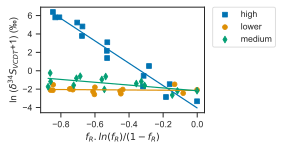

In [429]:
# Group by treatment
df_group = df_master.groupby(['treatment'])

# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))

# Define markers
markers = ['s','o','d']

# Define fig and axes
fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    #Calculate trendline  
    z = np.polyfit(data.xaxis_linreg, data.d34S_sulfate, 1)
    p = np.poly1d(z)
 
    # Plot fit
    ax.plot(data.xaxis_linreg, p(data.xaxis_linreg), c=colors[i])
    
    # Plot experimental data
    ax.scatter(data.xaxis_linreg, data.d34S_sulfate, color=colors[i], marker=markers[i],
              label = group)
    #ax.set_title('DddY')
    ax.set_xlabel('$f_{R}.ln (f_{R})/(1-f_{R})$')
    ax.set_ylabel('ln ($\delta{}^{34}S_{VCDT}$+1) (‰)')
    #ax.set_ylim(-3,-1,1)

#Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#Save figure
fig.savefig(f'{homedir}/d_alk/figures/d_alk_fr_sulfate.pdf', bbox_inches='tight')

Notes:
-The control must be repeated and in triplicates, with newly autoclaved media. these values must be substituted as the 0 for one of the bs and d.
-Temporarily, a0 was relabelled as d0 and c0 for the EA measurements.